# 03 - SnakeCLEF - Train Classifier on Cropped Images

In [1]:
import os

os.chdir('..')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch

from src.core import models, training, data, metrics, loss_functions
from src.utils import nb_setup, visualization as viz
from src.dev import experiments as exp

BBOX_DATA_DIR = '03_informed_augmentation/data_snake/'
DATA_DIR = 'data/snake_clef2021_dataset/'
TRAIN_SET_DIR = 'train'

SEED = 42

nb_setup.init()
nb_setup.set_random_seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

Device: cuda


In [3]:
OPTIONS = ['crop', 'full and crop', 'full and crop (random)',
           'full and crop (6 channels)', 'full and crop (mixup)']
OPTION = 'full and crop (mixup)'
assert OPTION in OPTIONS

MARGIN = 0.0

# mixup arguments
ALPHA = 0.5
MIXUP_P = 0.25
mixup_kwg = {}
if OPTION == 'full and crop (mixup)':
    mixup_kwg['alpha'] = float(ALPHA)
    mixup_kwg['mixup_p'] = float(MIXUP_P)

no_epochs = 30
if OPTION == 'full and crop':
    no_epochs = no_epochs // 2

In [4]:
# create training 
config = exp.create_config(
    data='clef2021',
    model='efficientnet_b0',
    loss='ce',
    opt='sgd',
    no_epochs=no_epochs,
    batch_size=64,
    total_batch_size=64,
    learning_rate=0.01,
    weight='none',
    dataset='mini_cleaned',
    scheduler='reduce_lr_on_plateau',
    note=f'trained on {OPTION}',
    **mixup_kwg
)

# include configuration from model
_model_config = models.get_model(config.model, pretrained=False).pretrained_config
config.update(_model_config)

# save config file
config.save(DATA_DIR + config.specs_name)

# create loss, optimizer and scheduler functions
loss_fn = loss_functions.LOSSES[config.loss]
weight_fn = loss_functions.WEIGHTING[config.weight]
opt_fn = training.OPTIMIZERS[config.opt]
sched_fn = training.SCHEDULERS[config.scheduler]

DATASETS = {
    'full': 'SnakeCLEF2021_train_metadata_PROD.csv',
    'mini': 'SnakeCLEF2021_train_metadata_mini_PROD.csv',
    'full_cleaned': 'SnakeCLEF2021_train_metadata_cleaned.csv',
    'mini_cleaned': 'SnakeCLEF2021_train_metadata_mini.csv'
}

print(config)

Config(
* model_name: clef2021_efficientnet_b0_ce_11-25-2021_19-12-51
* history_file: clef2021_efficientnet_b0_ce_11-25-2021_19-12-51.csv
* specs_name: clef2021_efficientnet_b0_ce_11-25-2021_19-12-51.json
* model: efficientnet_b0
* loss: ce
* opt: sgd
* no_epochs: 30
* batch_size: 64
* total_batch_size: 64
* learning_rate: 0.01
* weight: none
* dataset: mini_cleaned
* scheduler: reduce_lr_on_plateau
* note: trained on full and crop (mixup)
* alpha: 0.5
* mixup_p: 0.25
* pretrained_checkpoint: tf_efficientnet_b0
* input_size: 224
* image_mean: (0.485, 0.456, 0.406)
* image_std: (0.229, 0.224, 0.225))


## Load the Data

In [5]:
# load metadata
train_df = pd.read_csv(DATA_DIR + DATASETS[config.dataset])
valid_df = pd.read_csv(DATA_DIR + 'SnakeCLEF2021_test_metadata_cleaned.csv')

classes = np.unique(train_df['binomial'])
no_classes = len(classes)
assert no_classes == len(np.unique(valid_df['binomial']))
print(f'No classes: {no_classes}')
print(f'Train set length: {len(train_df):,d}')
print(f'Validation set length: {len(valid_df):,d}')

No classes: 770
Train set length: 70,440
Validation set length: 26,227


In [6]:
species = np.unique(train_df['binomial'])

# load country-species map, country-country LuT and rename countries
country_map_df = pd.read_csv(DATA_DIR + 'species_to_country_mapping.csv', index_col=0)
country_weights = metrics.clean_country_map(country_map_df, species, missing_val=0)

Mean bounding box area: 0.36305
Median bounding box area: 0.34351


<AxesSubplot:ylabel='Frequency'>

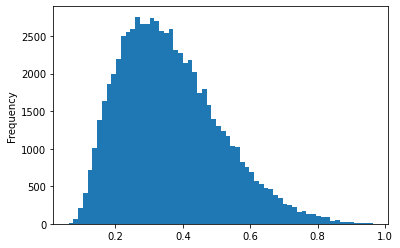

In [7]:
# include bbox annotations to the training set
bbox_df = pd.read_csv(BBOX_DATA_DIR + 'SnakeCLEF_bbox_annotations.csv')
bbox_df = bbox_df.drop_duplicates('UUID')
# assert len(bbox_df) >= len(train_df)
if MARGIN > 0:
    bbox_df['xmin'] = bbox_df['xmin'].apply(lambda x: max(0, x - MARGIN))
    bbox_df['ymin'] = bbox_df['ymin'].apply(lambda x: max(0, x - MARGIN))
    bbox_df['xmax'] = bbox_df['xmax'].apply(lambda x: min(1, x + MARGIN))
    bbox_df['ymax'] = bbox_df['ymax'].apply(lambda x: min(1, x + MARGIN))
    print(f'Making saliency boxes bigger by: {MARGIN}')
train_df = train_df.merge(bbox_df, 'left', on='UUID', validate='one_to_one')
valid_df = valid_df.merge(bbox_df, 'left', on='UUID', validate='one_to_one')

# create bbox column
for _df in [train_df, valid_df]:
    _df['bbox'] = _df[['xmin', 'ymin', 'xmax', 'ymax']].apply(lambda r: data.BBox(*r.values), axis=1)
    _df['bbox_area'] = _df['bbox'].apply(lambda bbox: bbox.area)

# get stats about bounding boxes
print('Mean bounding box area: {:.5f}'.format(train_df['bbox_area'].mean()))
print('Median bounding box area: {:.5f}'.format(train_df['bbox_area'].median()))
train_df['bbox_area'].plot(kind='hist', bins=64)

## Create Cropping Image DataLoader

In [10]:
from torch.utils.data import DataLoader
from torchvision import transforms as T
import PIL


class CombinedImageCroppingDataset(data.ImageCroppingDataset):
    def __getitem__(self, idx):
        img, label, bbox = self.get_item(idx, crop=False, return_bbox=True)
        img_cropped = self.crop_tfm(img, bbox)

        resize_tfm = T.RandomResizedCrop(self.crop_tfm.size, scale=(0.8, 1.0))
        img = resize_tfm(img)
        img = self.transform_image(img)
        img_cropped = self.transform_image(img_cropped)
        img = torch.cat([img, img_cropped], dim=0)

        if self._label2id:
            label = self._label2id[label]
        return img, label


class MixupImageCroppingDataset(data.ImageCroppingDataset):
    def __init__(self, df, img_path_col, label_col, bbox_col,
                 transforms, path='.', labels=None, encode_labels=True,
                 crop_p=1.0, alpha=0.5, mixup_p=0.25):
        super().__init__(df, img_path_col, label_col, bbox_col, 
                         transforms, path, labels, encode_labels, crop_p)
        self.alpha = alpha
        self.mixup_p = mixup_p

    def get_item(self, idx, *, crop=True, return_bbox=False):
        img, label, bbox = super().get_item(idx, crop=False, return_bbox=True)
        if crop:
            if self.alpha == 0.0:
                img = img.resize(self.size, resample=PIL.Image.BILINEAR)
            elif self.alpha == 1.0:
                img = self.crop_tfm(img, bbox)
            else:
                if self.mixup_p >= np.random.rand(1):
                    img_crop = self.crop_tfm(img, bbox)
                    img = img.resize(self.size, resample=PIL.Image.BILINEAR)
                    # img = ((img * (1-self.alpha)) + (img_crop * self.alpha)).astype(int)
                    img = PIL.Image.blend(img, img_crop, self.alpha)  # out = image1*(1.0 - alpha) + image2*alpha
                else:
                    img = self.crop_tfm(img, bbox)

        return (img, label, bbox) if return_bbox else (img, label)


def get_dataloader(dataset_cls, df, img_path_col, label_col, path='.', transforms=None,
                   batch_size=32, shuffle=True, num_workers=4, sampler=None,
                   bbox_col=None, labels=None, encode_labels=True, **kwargs):
    dataset = dataset_cls(
        df, img_path_col, label_col, path=path, bbox_col=bbox_col,
        transforms=transforms, labels=labels, encode_labels=encode_labels, **kwargs)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle,
                            num_workers=num_workers, sampler=sampler)
    return dataloader

In [11]:
# adjust training data
trainset_cls = data.ImageCroppingDataset
validset_cls = data.ImageCroppingDataset
train_crop_p = 1.0
in_chans = 3
if OPTION == 'crop':
    pass
elif OPTION == 'full and crop':
    print(f'Original train df size: {len(train_df):,d}')
    _train_df = train_df.copy()
    _train_df['bbox'] = _train_df['bbox'].apply(lambda _: data.BBox(0, 0, 1, 1))
    train_df = pd.concat([train_df, _train_df], axis=0)
    print(f'Full and cropped train df size: {len(train_df):,d}')
elif OPTION == 'full and crop (random)':
    train_crop_p = 0.5
elif OPTION == 'full and crop (6 channels)':
    in_chans = 6
    trainset_cls = CombinedImageCroppingDataset
    validset_cls = CombinedImageCroppingDataset
elif OPTION == 'full and crop (mixup)':
    trainset_cls = MixupImageCroppingDataset

print(f'Using "{trainset_cls.__name__}" trainng set class.')
print(f'Using "{validset_cls.__name__}" validation set class.')

Using "MixupImageCroppingDataset" trainng set class.
Using "ImageCroppingDataset" validation set class.


Cropping will be on random with probability 1.0


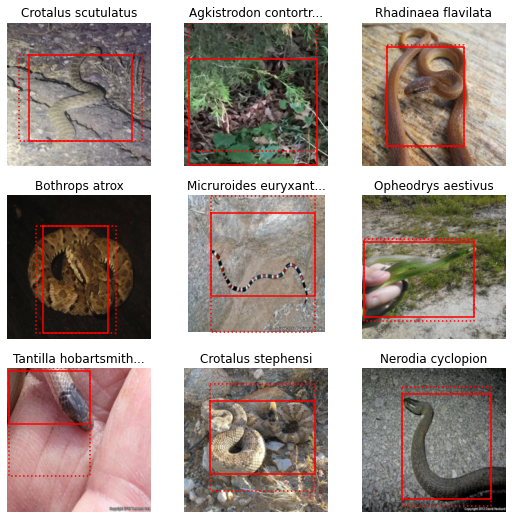

In [13]:
# create transforms
train_tfms, valid_tfms = data.get_transforms(
    size=config.input_size, mean=config.image_mean,
    std=config.image_std)

# create data loaders
trainloader = get_dataloader(
    trainset_cls, train_df, img_path_col='image_path', label_col='binomial',
    bbox_col='bbox', labels=classes,
    path=DATA_DIR + TRAIN_SET_DIR, transforms=train_tfms,
    batch_size=config.batch_size, shuffle=True, num_workers=4, **mixup_kwg)
validloader = get_dataloader(
    validset_cls, valid_df, img_path_col='image_path', label_col='binomial',
    bbox_col='bbox', labels=classes,
    path=DATA_DIR + TRAIN_SET_DIR, transforms=valid_tfms,
    batch_size=config.batch_size, shuffle=False, num_workers=4)

# set probability of cropping each image
trainloader.dataset.crop_tfm.p = train_crop_p
print(f'Cropping will be on random with probability {train_crop_p}')

trainloader.dataset.show_items()

In [ ]:
# # 6 channels - validate functionality of the dataset
# for img, label in validloader: break

# print(img.shape)

# fig, (ax1, ax2, ax3) = viz.create_fig(ncols=3, colsize=3, rowsize=3)
# validloader.dataset.show_item(1, ax=ax1)
# viz.imshow(img[1, :3], ax=ax2)
# viz.imshow(img[1, 3:], ax=ax3)

### Review Cropping Method

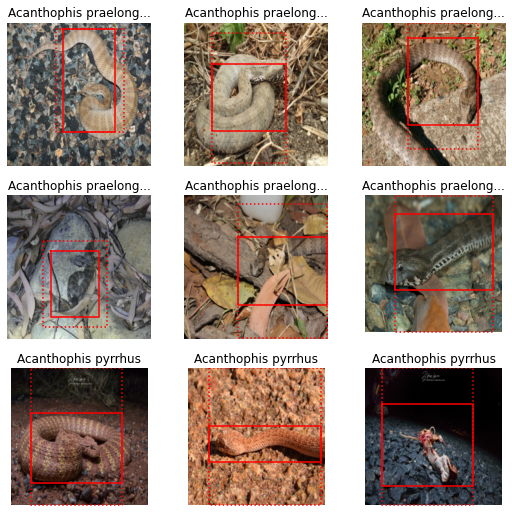

In [14]:
trainloader.dataset.show_items(50)

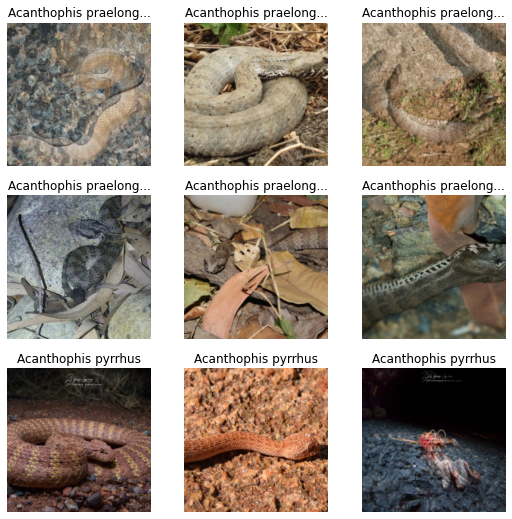

In [15]:
trainloader.dataset.show_items(50, apply_transforms=True)

## Train the Model

In [ ]:
from torch.optim import lr_scheduler
from src.utils.progress_log import ProgressBar


class Trainer2(training.Trainer):
    def train_epoch(self, optimizer, scheduler=None, pbar=None, return_preds=False):
        model = self.model
        dataloader = self.trainloader
        validloader = self.validloader
        criterion = self.criterion
        accumulation_steps = self.accumulation_steps
        device = self.device
        if pbar is None:
            pbar = ProgressBar().progress_bar

        model.to(device)
        model.train()
        optimizer.zero_grad()
        avg_loss = 0.
        preds_all, targs_all = [], []
        for i, (imgs, targs) in pbar(enumerate(dataloader), total=len(dataloader)):
            imgs = imgs.to(device)
            targs = targs.to(device)

            preds = model(imgs)
            loss = criterion(preds, targs)
            avg_loss += loss.item() / len(dataloader)

            # scale the loss to the mean of the accumulated batch size
            loss = loss / accumulation_steps
            loss.backward()

            # make optimizer step
            if (i - 1) % accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad()
                if scheduler is not None and not isinstance(scheduler, lr_scheduler.ReduceLROnPlateau):
                    scheduler.step()

            if i == (len(trainloader) // 2):
                preds, targs, valid_loss = self.predict(
                        self.validloader, pbar=pbar)
                # update ReduceLROnPlateau scheduler (if available)
                if (valid_loss is not None and scheduler is not None
                    and isinstance(scheduler, lr_scheduler.ReduceLROnPlateau)):
                    scheduler.step(valid_loss)  # scores[self.primary_metric]

            if return_preds:
                preds_all.append(preds.detach().cpu().numpy())
                targs_all.append(targs.detach().cpu().numpy())

        if return_preds:
            preds_all = np.concatenate(preds_all, axis=0)
            targs_all = np.concatenate(targs_all, axis=0)
        else:
            preds_all, targs_all = None, None
        return preds_all, targs_all, avg_loss

In [13]:
# create model
model = models.get_model(config.model, no_classes, pretrained=True, in_chans=in_chans)
assert np.all([param.requires_grad for param in model.parameters()])

# create loss
freq = train_df['binomial'].value_counts()[trainloader.dataset.labels].values
weights = weight_fn(freq)
criterion = loss_fn(weight=torch.Tensor(weights).to(device) if weights is not None else None)

# create trainer
trainer_cls = training.Trainer
if OPTION == 'full and crop':
    trainer_cls = Trainer2
trainer = trainer_cls(
    model,
    trainloader,
    criterion,
    opt_fn,
    sched_fn,
    validloader=validloader,
    accumulation_steps=config.total_batch_size // config.batch_size,
    path=DATA_DIR,
    model_filename=config.model_name,
    history_filename=config.history_file,
    metrics=[metrics.CountryF1Score(country_weights)],
    device=device)

In [ ]:
# train model
trainer.train(no_epochs=config.no_epochs, lr=config.learning_rate)

## Create Predictions on Full Images

In [ ]:
# create validloader with full images
validloader_full = data.get_dataloader(
    valid_df, img_path_col='image_path', label_col='binomial',
    path=DATA_DIR + TRAIN_SET_DIR, transforms=valid_tfms, labels=classes,
    batch_size=config.batch_size, shuffle=False, num_workers=4)

# load fine-tuned checkpoint
training.load_model(model, config.model_name, path=DATA_DIR + 'models')

# create predictions
pred, targ, _ = training.predict(model, validloader_full)

# compute scores
scores = training.classification_scores(pred, targ)
scores

In [ ]:
from src.utils.progress_log import CSVProgress

# save scores
csv_progress = CSVProgress(f'{config.model_name}_full.csv', DATA_DIR)
_scores = {'epoch': None, 'train_loss': None, 'valid_loss': None,
           **scores, 'time': None}
csv_progress.log_epoch_scores(_scores)